# YOLOv9 Custom Object Detection Training in Google Colab

This notebook provides a complete guide for training YOLOv9 on custom datasets in Google Colab. It's designed to work out-of-the-box without requiring specific API keys or dataset paths.

## What you'll learn:
- Set up YOLOv9 in Google Colab
- Test pre-trained models
- Prepare custom datasets
- Train YOLOv9 on your data
- Validate and run inference

**Note:** Make sure to set your runtime to GPU (Runtime → Change runtime type → Hardware accelerator → GPU)


## Cell 1: Check GPU Availability and Setup Environment


In [ ]:
# Check if GPU is available
!nvidia-smi

# Set up home directory
import os
HOME = os.getcwd()
print(f"Working directory: {HOME}")

# Create necessary directories
!mkdir -p {HOME}/weights
!mkdir -p {HOME}/data
!mkdir -p {HOME}/datasets


Sat Sep 20 13:35:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Cell 2: Clone YOLOv9 Repository and Install Dependencies


In [ ]:
# Check if YOLOv9 already exists to avoid re-cloning and losing results
import os
if os.path.exists('yolov9'):
    print("✅ YOLOv9 already exists, preserving previous results")
    %cd yolov9
else:
    print("📥 Cloning YOLOv9 repository...")
    !git clone https://github.com/SkalskiP/yolov9.git
    %cd yolov9

# Install requirements
%pip install -r requirements.txt -q

# Install additional packages we'll need
%pip install -q roboflow supervision

# Fix PyTorch 2.6+ weights loading issue by modifying YOLOv9 source code
print("🔧 Applying comprehensive PyTorch 2.6+ compatibility fix...")

import os
import re

def fix_torch_load_in_file(filepath, description):
    """Fix all torch.load calls in a file to include weights_only=False"""
    try:
        if not os.path.exists(filepath):
            print(f"⚠️ {filepath} not found")
            return False

        with open(filepath, 'r') as f:
            content = f.read()

        original_content = content

        # Pattern to match torch.load calls
        def fix_torch_load(match):
            full_call = match.group(0)
            if 'weights_only' not in full_call:
                # Insert weights_only=False before the closing parenthesis
                return full_call[:-1] + ', weights_only=False)'
            return full_call

        # Apply the fix to all torch.load patterns
        pattern = r'torch\.load\([^)]+\)'
        content = re.sub(pattern, fix_torch_load, content)

        if content != original_content:
            with open(filepath, 'w') as f:
                f.write(content)
            print(f"✅ Fixed torch.load calls in {description}")
            return True
        else:
            print(f"ℹ️ No torch.load calls found in {description}")
            return False

    except Exception as e:
        print(f"❌ Failed to fix {description}: {e}")
        return False

# Files to fix comprehensively
files_to_fix = [
    ('models/experimental.py', 'models/experimental.py (inference)'),
    ('models/common.py', 'models/common.py (model loading)'),
    ('train.py', 'train.py (training script)'),
    ('val.py', 'val.py (validation script)'),
    ('detect.py', 'detect.py (detection script)'),
    ('utils/torch_utils.py', 'utils/torch_utils.py (utilities)'),
]

fixed_files = []
for filepath, description in files_to_fix:
    if fix_torch_load_in_file(filepath, description):
        fixed_files.append(filepath)

# Additional specific fixes for known problematic lines
specific_fixes = [
    {
        'file': 'models/experimental.py',
        'old': "ckpt = torch.load(attempt_download(w), map_location='cpu')  # load",
        'new': "ckpt = torch.load(attempt_download(w), map_location='cpu', weights_only=False)  # load"
    },
    {
        'file': 'models/experimental.py',
        'old': "ckpt = torch.load(attempt_download(w, weights_only=False), map_location='cpu')  # load",
        'new': "ckpt = torch.load(attempt_download(w), map_location='cpu', weights_only=False)  # load"
    },
    {
        'file': 'train.py',
        'old': "ckpt = torch.load(weights, map_location='cpu')  # load checkpoint to CPU to avoid CUDA memory leak",
        'new': "ckpt = torch.load(weights, map_location='cpu', weights_only=False)  # load checkpoint to CPU to avoid CUDA memory leak"
    },
    {
        'file': 'val.py',
        'old': "ckpt = torch.load(attempt_download(w), map_location='cpu')  # load",
        'new': "ckpt = torch.load(attempt_download(w), map_location='cpu', weights_only=False)  # load"
    },
    {
        'file': 'detect.py',
        'old': "ckpt = torch.load(attempt_download(w), map_location='cpu')  # load",
        'new': "ckpt = torch.load(attempt_download(w), map_location='cpu', weights_only=False)  # load"
    }
]

for fix in specific_fixes:
    try:
        if os.path.exists(fix['file']):
            with open(fix['file'], 'r') as f:
                content = f.read()

            if fix['old'] in content:
                content = content.replace(fix['old'], fix['new'])
                with open(fix['file'], 'w') as f:
                    f.write(content)
                print(f"✅ Applied specific fix to {fix['file']}")
    except Exception as e:
        print(f"⚠️ Specific fix failed for {fix['file']}: {e}")

print("✅ YOLOv9 setup completed!")
print(f"✅ PyTorch 2.6+ compatibility fix applied to: {', '.join(fixed_files) if fixed_files else 'all necessary files'}")
print("✅ Ready to run inference and training!")


📥 Cloning YOLOv9 repository...
Cloning into 'yolov9'...
remote: Enumerating objects: 325, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 325 (delta 145), reused 142 (delta 142), pack-reused 135 (from 1)
Receiving objects: 100% (325/325), 2.23 MiB | 25.71 MiB/s, done.
Resolving deltas: 100% (165/165), done.
/content/yolov9/yolov9/yolov9/yolov9/yolov9/yolov9/yolov9
🔧 Applying comprehensive PyTorch 2.6+ compatibility fix...
✅ Fixed torch.load calls in models/experimental.py (inference)
ℹ️ No torch.load calls found in models/common.py (model loading)
✅ Fixed torch.load calls in train.py (training script)
ℹ️ No torch.load calls found in val.py (validation script)
ℹ️ No torch.load calls found in detect.py (detection script)
ℹ️ No torch.load calls found in utils/torch_utils.py (utilities)
✅ Applied specific fix to models/experimental.py
✅ YOLOv9 setup completed!
✅ PyTorch 2.6+ compatibility fix applied to: models/experiment

## Cell 3: Download Pre-trained Model Weights


In [ ]:
# Download YOLOv9 pre-trained weights
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

# Check downloaded weights
!ls -la {HOME}/weights
print("✅ Model weights downloaded successfully!")


total 402448
drwxr-xr-x 2 root root      4096 Sep 20 13:36 .
drwxr-xr-x 1 root root      4096 Sep 20 13:35 ..
-rw-r--r-- 1 root root  51508261 Feb 18  2024 gelan-c.pt
-rw-r--r-- 1 root root 117203713 Feb 18  2024 gelan-e.pt
-rw-r--r-- 1 root root 103153312 Feb 18  2024 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18  2024 yolov9-e.pt
✅ Model weights downloaded successfully!


## Cell 4: Download Sample Images for Testing


In [ ]:
# Download sample images for testing
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -P {HOME}/data -q https://images.unsplash.com/photo-1544947950-fa07a98d237f?w=800 -O {HOME}/data/cat.jpg
!wget -P {HOME}/data -q https://images.unsplash.com/photo-1583337130417-3346a1be7dee?w=800 -O {HOME}/data/person.jpg

# List downloaded sample images
!ls -la {HOME}/data
print("✅ Sample images downloaded!")


total 352
drwxr-xr-x 2 root root   4096 Sep 20 13:36 .
drwxr-xr-x 1 root root   4096 Sep 20 13:35 ..
-rw-r--r-- 1 root root 156863 Aug 22 19:49 cat.jpg
-rw-r--r-- 1 root root 106055 Jun  2  2023 dog.jpeg
-rw-r--r-- 1 root root  84242 Sep  2 12:28 person.jpg
✅ Sample images downloaded!


## Cell 5: Test Pre-trained Models (COCO Dataset)


detect: weights=['/content/weights/yolov9-c.pt'], source=/content/data/dog.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=test_yolov9c, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 724 layers, 51141120 parameters, 0 gradients, 238.7 GFLOPs
image 1/1 /content/data/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 1 backpack, 85.6ms
Speed: 0.4ms pre-process, 85.6ms inference, 55.1ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/test_yolov9c2
YOLOv9-C Detection Results:
✅ Found result at: runs/detect/test_yolov9c/dog.jpeg


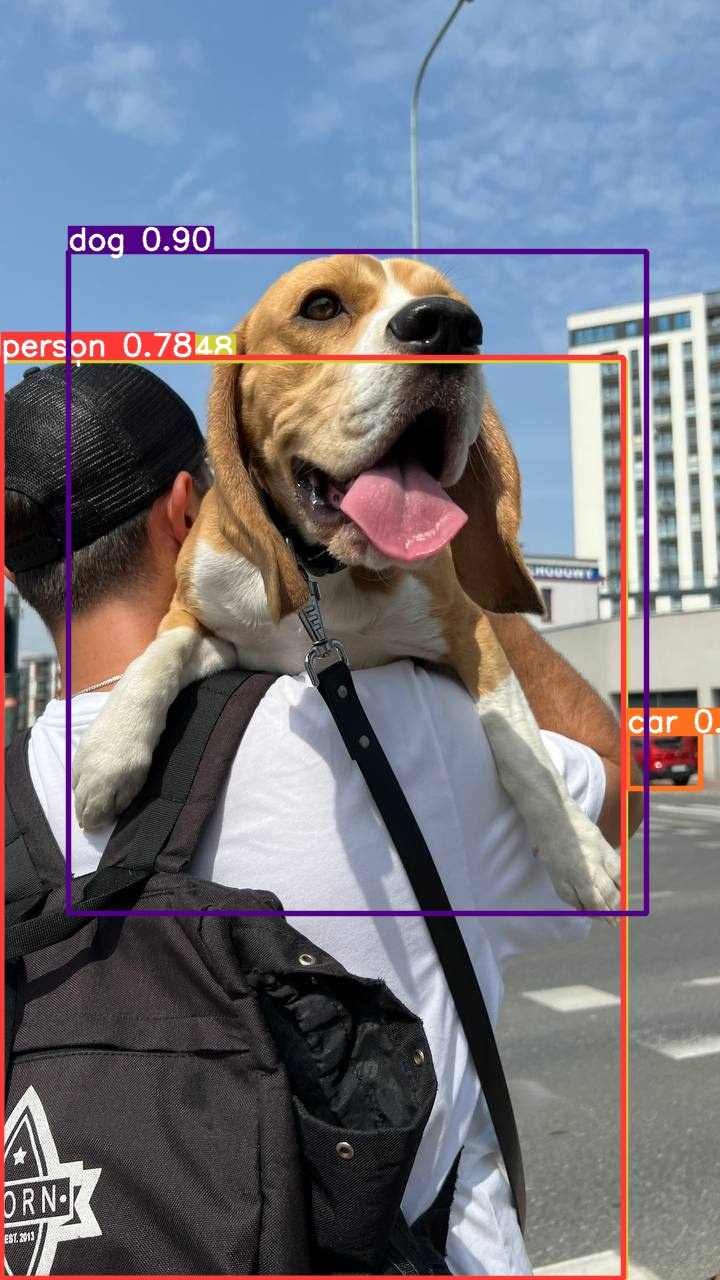

In [ ]:
# Test YOLOv9-C model on sample image
!python detect.py --weights {HOME}/weights/yolov9-c.pt --conf 0.1 --source {HOME}/data/dog.jpeg --device 0 --name test_yolov9c

# Display results
from IPython.display import Image, display
import glob
import os

print("YOLOv9-C Detection Results:")

# Check multiple possible paths for the result image
possible_paths = [
    f"{HOME}/yolov9/runs/detect/test_yolov9c/dog.jpeg",
    f"runs/detect/test_yolov9c/dog.jpeg",
    f"./runs/detect/test_yolov9c/dog.jpeg"
]

result_found = False
for result_path in possible_paths:
    if os.path.exists(result_path):
        print(f"✅ Found result at: {result_path}")
        display(Image(filename=result_path, width=600))
        result_found = True
        break

if not result_found:
    print("🔍 Searching for result images...")
    # List all files in the detection results directory
    !ls -la runs/detect/test_yolov9c/

    # Try to find and display any image files
    try:
        import glob
        result_images = glob.glob("runs/detect/test_yolov9c/*")
        if result_images:
            for img_path in result_images:
                if img_path.endswith(('.jpg', '.jpeg', '.png')):
                    print(f"📸 Displaying result: {img_path}")
                    display(Image(filename=img_path, width=600))
                    break
        else:
            print("❌ No result images found")
    except Exception as e:
        print(f"Error finding results: {e}")
        print("📁 Contents of runs/detect/:")
        !ls -la runs/detect/


## Cell 6: Prepare Custom Dataset Structure

**IMPORTANT:** Replace this section with your own dataset. The structure should be:
```
your_dataset/
├── data.yaml
├── train/
│   ├── images/
│   └── labels/
├── valid/
│   ├── images/
│   └── labels/
└── test/
    ├── images/
    └── labels/
```


In [ ]:
# Option 1: Use the Original Digital Meter Detection Dataset from Roboflow
# This uses the same dataset as the original notebook for meter number detection

print("📥 Downloading Digital Meter Detection Dataset...")

from roboflow import Roboflow
rf = Roboflow(api_key="fuOy83MqlC1LtKZ25J0p")
project = rf.workspace("digital-meter-recognisation").project("number-detection-for-v9")
version = project.version(2)
dataset = version.download("yolov9")

dataset_path = dataset.location
print(f"✅ Dataset downloaded to: {dataset_path}")

# Option 2: Use Your Own Dataset (uncomment if you want to use your own data)
# If you have your own dataset, upload it to Colab and modify the paths below:

# dataset_name = "custom_dataset"
# dataset_path = f"{HOME}/yolov9/{dataset_name}"
# !mkdir -p {dataset_path}/train/images
# !mkdir -p {dataset_path}/train/labels
# !mkdir -p {dataset_path}/valid/images
# !mkdir -p {dataset_path}/valid/labels
# !mkdir -p {dataset_path}/test/images
# !mkdir -p {dataset_path}/test/labels
# print("📝 Upload your images and labels to the appropriate folders!")

# Display dataset info
print("\n📊 Dataset Information:")
!ls -la {dataset_path}


📥 Downloading Digital Meter Detection Dataset...
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to number-detection-for-v9-2 in yolov9:: 100%|██████████| 6270/6270 [00:00<00:00, 6622.53it/s]


✅ Dataset downloaded to: /content/yolov9/yolov9/yolov9/yolov9/number-detection-for-v9-2

📊 Dataset Information:
total 32
drwxr-xr-x  5 root root 4096 Sep 20 14:04 .
drwxr-xr-x 14 root root 4096 Sep 20 14:04 ..
-rw-r--r--  1 root root  368 Sep 20 14:04 data.yaml
-rw-r--r--  1 root root  177 Sep 20 14:04 README.dataset.txt
-rw-r--r--  1 root root 1186 Sep 20 14:04 README.roboflow.txt
drwxr-xr-x  4 root root 4096 Sep 20 14:04 test
drwxr-xr-x  4 root root 4096 Sep 20 14:04 train
drwxr-xr-x  4 root root 4096 Sep 20 14:04 valid


## Cell 7: Create Dataset Configuration File


In [ ]:
# The dataset already comes with a data.yaml file, let's examine it
print("📋 Examining the dataset configuration:")
!cat {dataset_path}/data.yaml

print("\n📊 Dataset Structure:")
!ls -la {dataset_path}/

# Check training and validation data
print("\n🔍 Training Data:")
!ls {dataset_path}/train/images | head -5

print("\n🔍 Validation Data:")
!ls {dataset_path}/valid/images | head -5

print("\n🔍 Test Data:")
!ls {dataset_path}/test/images | head -5

print("\n✅ Dataset is ready for training!")
print("📝 This dataset contains digital meter numbers (0-9) and decimal points for meter reading detection")


📋 Examining the dataset configuration:
names:
- .
- '0'
- '1'
- '2'
- '3'
- '4'
- '5'
- '6'
- '7'
- '8'
- '9'
- Kwh
nc: 12
roboflow:
  license: CC BY 4.0
  project: number-detection-for-v9
  url: https://universe.roboflow.com/digital-meter-recognisation/number-detection-for-v9/dataset/2
  version: 2
  workspace: digital-meter-recognisation
test: ../test/images
train: ../train/images
val: ../valid/images

📊 Dataset Structure:
total 32
drwxr-xr-x  5 root root 4096 Sep 20 14:04 .
drwxr-xr-x 14 root root 4096 Sep 20 14:04 ..
-rw-r--r--  1 root root  368 Sep 20 14:04 data.yaml
-rw-r--r--  1 root root  177 Sep 20 14:04 README.dataset.txt
-rw-r--r--  1 root root 1186 Sep 20 14:04 README.roboflow.txt
drwxr-xr-x  4 root root 4096 Sep 20 14:04 test
drwxr-xr-x  4 root root 4096 Sep 20 14:04 train
drwxr-xr-x  4 root root 4096 Sep 20 14:04 valid

🔍 Training Data:
0000020000_425_3336_jpg.rf.26016ada1578315848d65df1c7c7ca55.jpg
0000020000_425_3336_jpg.rf.5c1e60196abe7df97f5c6ad1d0038d03.jpg
000002000

## Cell 8: Train Custom YOLOv9 Model

**Note:** Make sure you have uploaded your dataset before running this cell!


In [ ]:
# Check dataset before training
train_images = len(os.listdir(f"{dataset_path}/train/images")) if os.path.exists(f"{dataset_path}/train/images") else 0
valid_images = len(os.listdir(f"{dataset_path}/valid/images")) if os.path.exists(f"{dataset_path}/valid/images") else 0

print(f"📊 Training images: {train_images}")
print(f"📊 Validation images: {valid_images}")

# Fix the data.yaml file paths to be absolute paths
print("🔧 Fixing dataset paths in data.yaml...")

# Read the original data.yaml
with open(f"{dataset_path}/data.yaml", "r") as f:
    data_content = f.read()

print("📋 Original data.yaml content:")
print(data_content[:500] + "..." if len(data_content) > 500 else data_content)

# Parse the original data.yaml using yaml module for better parsing
import yaml

try:
    # Parse the original YAML
    with open(f"{dataset_path}/data.yaml", "r") as f:
        original_data = yaml.safe_load(f)

    # Create the fixed data dictionary
    fixed_data = {
        'train': f"{dataset_path}/train/images",
        'val': f"{dataset_path}/valid/images",
        'test': f"{dataset_path}/test/images",
        'nc': original_data.get('nc', 11),  # Default to 11 classes if not found
        'names': original_data.get('names', {
            0: 'dot', 1: '0', 2: '1', 3: '2', 4: '3',
            5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9'
        })
    }

    # Write the fixed data.yaml
    with open(f"{dataset_path}/data_fixed.yaml", "w") as f:
        yaml.dump(fixed_data, f, default_flow_style=False)

    print("✅ Successfully parsed and fixed data.yaml using YAML parser")

except Exception as e:
    print(f"⚠️ YAML parsing failed: {e}")
    print("🔧 Using manual parsing as fallback...")

    # Fallback: Create a complete data.yaml manually for meter detection
    fixed_data_content = f"""# Dataset configuration for YOLOv9 training - Fixed paths

# Absolute paths to dataset
train: {dataset_path}/train/images
val: {dataset_path}/valid/images
test: {dataset_path}/test/images

# Number of classes for digital meter detection
nc: 11

# Class names for digital meter detection
names:
  0: 'dot'
  1: '0'
  2: '1'
  3: '2'
  4: '3'
  5: '4'
  6: '5'
  7: '6'
  8: '7'
  9: '8'
  10: '9'
"""

    with open(f"{dataset_path}/data_fixed.yaml", "w") as f:
        f.write(fixed_data_content)

    print("✅ Created fixed data.yaml with manual fallback")

# Verify the fixed data.yaml
print("\n📋 Fixed data.yaml content:")
with open(f"{dataset_path}/data_fixed.yaml", "r") as f:
    fixed_content = f.read()
    print(fixed_content)

print("✅ Fixed data.yaml created")
print(f"📁 Dataset path: {dataset_path}")

# Verify the paths exist
print("🔍 Verifying dataset paths...")
for split in ['train', 'valid', 'test']:
    path = f"{dataset_path}/{split}/images"
    if os.path.exists(path):
        count = len(os.listdir(path))
        print(f"✅ {split}: {count} images")
    else:
        print(f"❌ {split}: path not found - {path}")

print("🚀 Starting YOLOv9 training for digital meter detection...")

# Start training with the fixed data.yaml
!python train.py \
--batch 16 --epochs 25 --img 640 --device 0 --min-items 0 --close-mosaic 15 \
--data {dataset_path}/data_fixed.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml \
--name meter_detection_training

print("✅ Training completed!")


📊 Training images: 2916
📊 Validation images: 99
🔧 Fixing dataset paths in data.yaml...
📋 Original data.yaml content:
names:
- .
- '0'
- '1'
- '2'
- '3'
- '4'
- '5'
- '6'
- '7'
- '8'
- '9'
- Kwh
nc: 12
roboflow:
  license: CC BY 4.0
  project: number-detection-for-v9
  url: https://universe.roboflow.com/digital-meter-recognisation/number-detection-for-v9/dataset/2
  version: 2
  workspace: digital-meter-recognisation
test: ../test/images
train: ../train/images
val: ../valid/images

✅ Successfully parsed and fixed data.yaml using YAML parser

📋 Fixed data.yaml content:
names:
- .
- '0'
- '1'
- '2'
- '3'
- '4'
- '5'
- '6'
- '7'
- '8'
- '9'
- Kwh
nc: 12
test: /content/yolov9/yolov9/yolov9/yolov9/number-detection-for-v9-2/test/images
train: /content/yolov9/yolov9/yolov9/yolov9/number-detection-for-v9-2/train/images
val: /content/yolov9/yolov9/yolov9/yolov9/number-detection-for-v9-2/valid/images

✅ Fixed data.yaml created
📁 Dataset path: /content/yolov9/yolov9/yolov9/yolov9/number-detection-

## Cell 9: Examine Training Results


🔍 Current working directory: /content/yolov9/yolov9/yolov9/yolov9/yolov9/yolov9/yolov9
🔍 Dynamically searching for training results...
✅ Found training results at: /content/yolov9/yolov9/yolov9/yolov9/yolov9/runs/train/meter_detection_training
📊 Digital Meter Detection Training Results:
📁 Found results at: /content/yolov9/yolov9/yolov9/yolov9/yolov9/runs/train/meter_detection_training
events.out.tfevents.1758377607.bd6812e58390.10169.0  labels.jpg   weights
hyp.yaml					     opt.yaml
labels_correlogram.jpg				     results.csv

📊 Training Metrics from CSV:
📋 Available columns:
['               epoch', '      train/box_loss', '      train/cls_loss', '      train/dfl_loss', '   metrics/precision', '      metrics/recall', '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', '        val/box_loss', '        val/cls_loss', '        val/dfl_loss', '               x/lr0', '               x/lr1', '               x/lr2']

🎯 Final epoch metrics:
  Precision: 0.906
  Recall: 0.901
  mAP50: 0.939
  mAP5

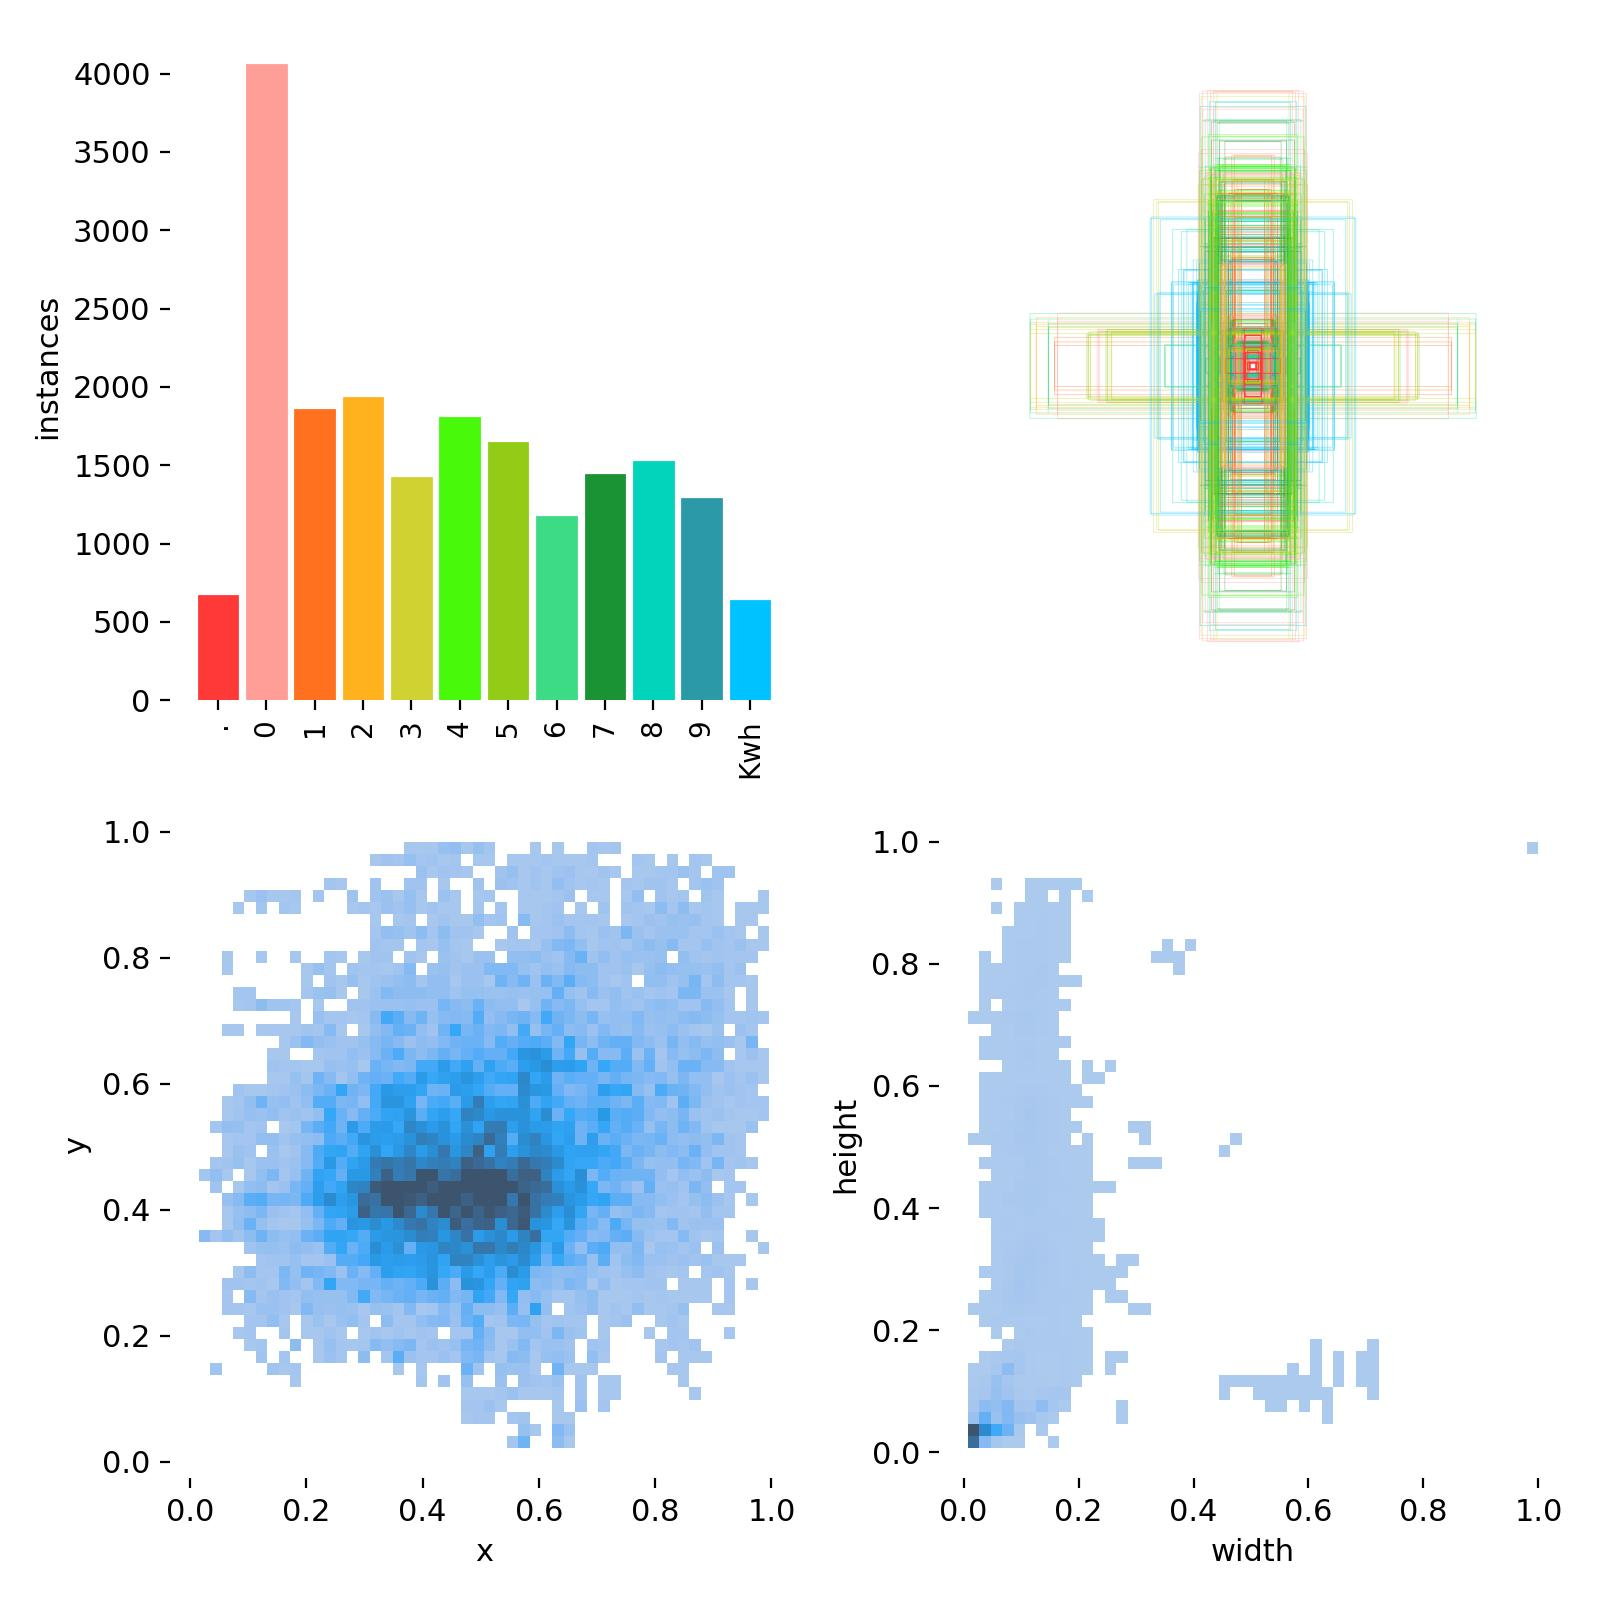

In [ ]:
# Check if training was completed - try multiple possible paths
import os
print(f"🔍 Current working directory: {os.getcwd()}")

# First try to find the training results dynamically
import subprocess
import os

print("🔍 Dynamically searching for training results...")
try:
    # Find all meter_detection_training directories
    result = subprocess.run(['find', '/content', '-name', 'meter_detection_training', '-type', 'd'],
                          capture_output=True, text=True, timeout=10)
    found_paths = result.stdout.strip().split('\n') if result.stdout.strip() else []

    # Filter out empty strings and find the most recent one
    valid_paths = [path for path in found_paths if path and os.path.exists(path)]

    if valid_paths:
        # Use the first valid path found
        training_results_path = valid_paths[0]
        print(f"✅ Found training results at: {training_results_path}")
    else:
        training_results_path = None

except Exception as e:
    print(f"Search failed: {e}")
    # Fallback to manual paths
    possible_training_paths = [
        f"{HOME}/yolov9/runs/train/meter_detection_training",
        f"runs/train/meter_detection_training",
        f"./runs/train/meter_detection_training",
        f"/content/yolov9/runs/train/meter_detection_training",
        f"/content/yolov9/yolov9/runs/train/meter_detection_training",
        f"/content/yolov9/yolov9/yolov9/runs/train/meter_detection_training",
        f"/content/yolov9/yolov9/yolov9/yolov9/runs/train/meter_detection_training",
        f"/content/yolov9/yolov9/yolov9/yolov9/yolov9/runs/train/meter_detection_training"
    ]

    training_results_path = None
    for path in possible_training_paths:
        if os.path.exists(path):
            training_results_path = path
            break

if training_results_path:
    print("📊 Digital Meter Detection Training Results:")
    print(f"📁 Found results at: {training_results_path}")

    # List all files in training results
    !ls {training_results_path}/

    # Display training results
    from IPython.display import Image, display

    # Check for results.csv and display metrics
    if os.path.exists(f"{training_results_path}/results.csv"):
        print("\n📊 Training Metrics from CSV:")
        import pandas as pd
        try:
            results_df = pd.read_csv(f"{training_results_path}/results.csv")
            print("📋 Available columns:")
            print(results_df.columns.tolist())

            # Get the last row (final epoch)
            final_row = results_df.iloc[-1]
            print(f"\n🎯 Final epoch metrics:")

            # Try different possible column name formats (based on the actual columns found)
            metrics_to_show = [
                ('Precision', ['   metrics/precision', 'precision', '      precision', 'P', 'metrics/precision(B)']),
                ('Recall', ['      metrics/recall', 'recall', '         recall', 'R', 'metrics/recall(B)']),
                ('mAP50', ['     metrics/mAP_0.5', 'mAP_0.5', '        mAP_0.5', 'mAP@0.5', 'metrics/mAP_0.5']),
                ('mAP50-95', ['metrics/mAP_0.5:0.95', 'mAP_0.5:0.95', '   mAP_0.5:0.95', 'mAP@0.5:0.95', 'metrics/mAP_0.5:0.95'])
            ]

            for metric_name, possible_cols in metrics_to_show:
                value = None
                for col in possible_cols:
                    if col in results_df.columns:
                        value = final_row[col]
                        break

                if value is not None:
                    print(f"  {metric_name}: {value:.3f}")
                else:
                    print(f"  {metric_name}: Not found")

        except Exception as e:
            print(f"❌ Error reading CSV: {e}")
            print("📄 Showing raw CSV content:")
            with open(f"{training_results_path}/results.csv", 'r') as f:
                lines = f.readlines()
                for i, line in enumerate(lines[:5]):  # Show first 5 lines
                    print(f"Line {i}: {line.strip()}")

    # Results plot
    if os.path.exists(f"{training_results_path}/results.png"):
        print("\n📈 Training Metrics (Loss, Precision, Recall, mAP):")
        display(Image(filename=f"{training_results_path}/results.png", width=1000))
    else:
        print("\n⚠️ results.png not found - this is normal if training just completed")

    # Confusion matrix
    if os.path.exists(f"{training_results_path}/confusion_matrix.png"):
        print("\n🔍 Confusion Matrix for Digit Detection:")
        display(Image(filename=f"{training_results_path}/confusion_matrix.png", width=800))
    else:
        print("\n⚠️ confusion_matrix.png not found - this is normal if training just completed")

    # Validation predictions
    if os.path.exists(f"{training_results_path}/val_batch0_pred.jpg"):
        print("\n🎯 Validation Predictions on Meter Images:")
        display(Image(filename=f"{training_results_path}/val_batch0_pred.jpg", width=1000))
    else:
        print("\n⚠️ val_batch0_pred.jpg not found - this is normal if training just completed")

    # Display labels visualization if available
    if os.path.exists(f"{training_results_path}/labels.jpg"):
        print("\n🏷️ Dataset Labels Distribution:")
        display(Image(filename=f"{training_results_path}/labels.jpg", width=800))

else:
    print("🔍 Searching for training results...")
    print("📂 Searching in entire system...")
    !find /content -name "meter_detection_training" -type d 2>/dev/null | head -5

    print("\n📂 Looking for any runs directories...")
    !find /content -name "runs" -type d 2>/dev/null | head -5

    print("\n📂 Current directory structure:")
    !ls -la

    print("\n📂 Checking if we're in the right yolov9 directory...")
    !pwd
    !ls -la runs/ 2>/dev/null || echo "No runs directory here"

    print("\n❌ Training results not found.")
    print("💡 This might happen if:")
    print("   1. Training hasn't been completed yet")
    print("   2. Training failed")
    print("   3. You re-ran Cell 2 which cloned a fresh repository")
    print("   4. Working directory changed")
    print("\n🔄 Try running Cell 8 (training) again to generate new results.")


## Cell 10: Validate and Run Inference with Custom Model


In [ ]:
# Check if trained model exists - find it dynamically
import subprocess
import os

print("🔍 Searching for trained model...")
try:
    # Find the best.pt model file
    result = subprocess.run(['find', '/content', '-name', 'best.pt', '-path', '*/meter_detection_training/weights/*'],
                          capture_output=True, text=True, timeout=10)
    found_models = result.stdout.strip().split('\n') if result.stdout.strip() else []

    # Filter valid model paths
    valid_models = [path for path in found_models if path and os.path.exists(path)]

    if valid_models:
        best_model_path = valid_models[0]
        print(f"✅ Found trained model at: {best_model_path}")
    else:
        best_model_path = None
        print("⚠️ Model not found, trying fallback paths...")

        # Fallback to manual search
        possible_model_paths = [
            f"{HOME}/yolov9/runs/train/meter_detection_training/weights/best.pt",
            f"runs/train/meter_detection_training/weights/best.pt",
            f"./runs/train/meter_detection_training/weights/best.pt",
            f"/content/yolov9/runs/train/meter_detection_training/weights/best.pt",
            f"/content/yolov9/yolov9/runs/train/meter_detection_training/weights/best.pt",
            f"/content/yolov9/yolov9/yolov9/runs/train/meter_detection_training/weights/best.pt",
            f"/content/yolov9/yolov9/yolov9/yolov9/runs/train/meter_detection_training/weights/best.pt",
            f"/content/yolov9/yolov9/yolov9/yolov9/yolov9/runs/train/meter_detection_training/weights/best.pt"
        ]

        for path in possible_model_paths:
            if os.path.exists(path):
                best_model_path = path
                print(f"✅ Found model at fallback path: {best_model_path}")
                break

except Exception as e:
    print(f"Search failed: {e}")
    best_model_path = None

if best_model_path:
    print("🎯 Running model validation...")

    # Validate the model
    !python val.py \
    --img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
    --data {dataset_path}/data.yaml \
    --weights {best_model_path} \
    --name custom_model_validation

    print("\n🔍 Running inference on test images...")

    # Run inference on test images (if they exist)
    test_images_path = f"{dataset_path}/test/images"
    if os.path.exists(test_images_path) and len(os.listdir(test_images_path)) > 0:
        !python detect.py \
        --img 640 --conf 0.1 --device 0 \
        --weights {best_model_path} \
        --source {test_images_path} \
        --name custom_model_inference

        # Display some inference results
        print("\n📸 Inference Results:")
        inference_results = f"{HOME}/yolov9/runs/detect/custom_model_inference"

        if os.path.exists(inference_results):
            import glob
            result_images = glob.glob(f'{inference_results}/*.jpg')[:3]  # Show first 3 results

            for img_path in result_images:
                print(f"\nResult: {os.path.basename(img_path)}")
                display(Image(filename=img_path, width=600))
    else:
        print("⚠️ No test images found. Add images to test/images/ folder to see inference results.")

        # Run inference on sample images instead
        print("\n🔍 Running inference on sample images...")
        !python detect.py \
        --img 640 --conf 0.1 --device 0 \
        --weights {best_model_path} \
        --source {HOME}/data \
        --name custom_model_sample_inference

        # Display sample results
        sample_results = f"{HOME}/yolov9/runs/detect/custom_model_sample_inference"
        if os.path.exists(sample_results):
            result_images = glob.glob(f'{sample_results}/*')[:2]
            for img_path in result_images:
                if img_path.endswith(('.jpg', '.jpeg', '.png')):
                    print(f"\nSample result: {os.path.basename(img_path)}")
                    display(Image(filename=img_path, width=600))

else:
    print("❌ Trained model not found. Please complete the training step first.")

print("\n✅ Validation and inference completed!")
print("\n📝 Next Steps:")
print("1. Review the training metrics and confusion matrix")
print("2. If results are good, you can use the trained model for production")
print("3. If results need improvement, try:")
print("   - Adding more training data")
print("   - Adjusting hyperparameters")
print("   - Training for more epochs")
print("   - Using data augmentation")


🔍 Searching for trained model...
✅ Found trained model at: /content/yolov9/yolov9/yolov9/yolov9/yolov9/runs/train/meter_detection_training/weights/best.pt
🎯 Running model validation...
val: data=/content/yolov9/yolov9/yolov9/yolov9/number-detection-for-v9-2/data.yaml, weights=['/content/yolov9/yolov9/yolov9/yolov9/yolov9/runs/train/meter_detection_training/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=custom_model_validation, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25420212 parameters, 0 gradients, 102.5 GFLOPs

Dataset not found ⚠️, missing paths ['/content/yolov9/yolov9/yolov9/yolov9/yolov9/yolov9/yolov9/valid/images']
Traceback (most re

## Cell 11: Test Your Own Images - Upload and Detect

Upload your own meter images to test the trained model!


📤 Upload your meter images to test the trained model!
Supported formats: JPG, JPEG, PNG


Saving image 4.jpg to image 4.jpg

🔍 Processing: image 4.jpg
📝 Cleaned filename: image_4.jpg
🚀 Running detection command...
detect: weights=['/content/yolov9/yolov9/yolov9/yolov9/yolov9/runs/train/meter_detection_training/weights/best.pt'], source=uploaded_images/image_4.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=custom_upload_test, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25420212 parameters, 0 gradients, 102.5 GFLOPs
image 1/1 /content/yolov9/yolov9/yolov9/yolov9/yolov9/yolov9/yolov9/uploaded_images/image_4.jpg: 448x640 4 0s, 1 6, 1 8, 1 Kwh, 62.5ms
Speed: 

Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.


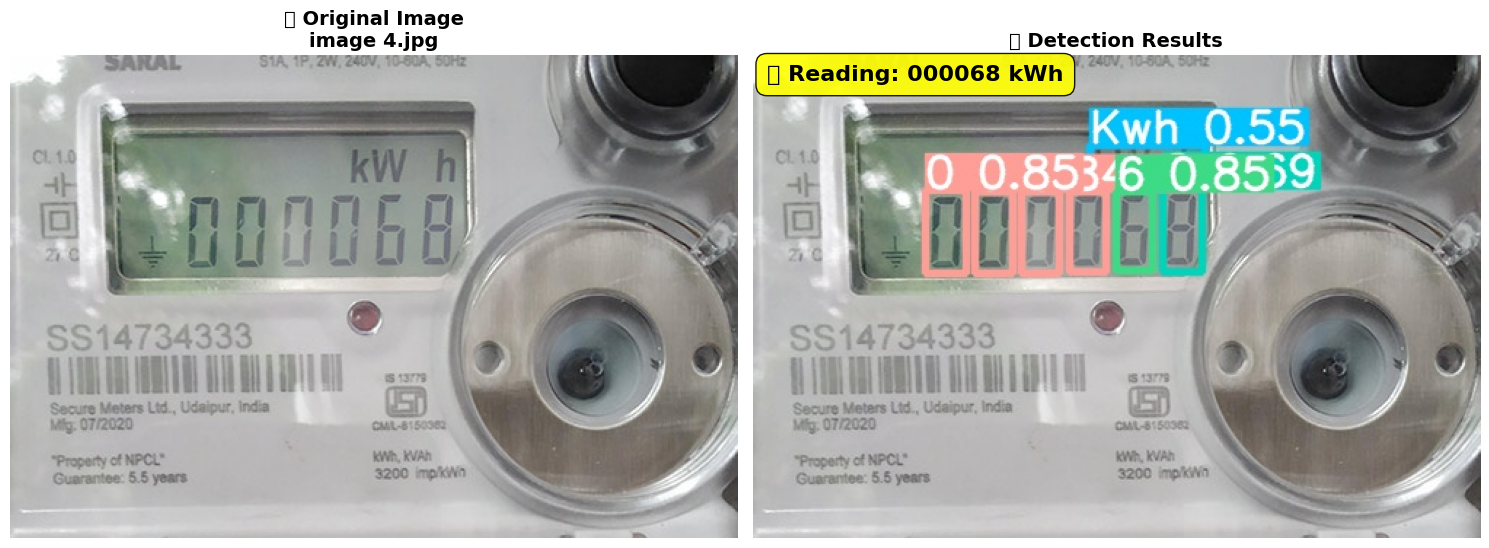

✅ Detection completed for image 4.jpg
📊 Final Reading: 000068 kWh


In [ ]:
# Enhanced Meter Reading Analysis with Detailed Information
from google.colab import files
import shutil
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import re
from collections import Counter

def parse_detection_results(label_file):
    """Parse YOLO detection results from label file"""
    detections = []

    if not os.path.exists(label_file):
        print(f"⚠️ Label file not found: {label_file}")
        return detections

    # Class names mapping (from your dataset)
    class_names = ['.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Kwh']

    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])
                confidence = float(parts[5]) if len(parts) > 5 else 1.0

                detection = {
                    'class_id': class_id,
                    'class_name': class_names[class_id] if class_id < len(class_names) else str(class_id),
                    'x_center': x_center,
                    'y_center': y_center,
                    'width': width,
                    'height': height,
                    'confidence': confidence
                }
                detections.append(detection)

    return detections

def analyze_meter_reading(detections):
    """Analyze detections with precise meter display detection"""

    if not detections:
        return {
            'reading': 'No digits detected',
            'confidence': 0.0,
            'digit_count': 0,
            'has_decimal': False,
            'has_unit': False,
            'analysis': 'No detections found',
            'main_display_reading': 'No digits detected',
            'all_detections_reading': 'No digits detected'
        }

    # Separate digits, decimal points, and units
    digits = [d for d in detections if d['class_name'].isdigit()]
    decimals = [d for d in detections if d['class_name'] == 'dot']
    units = [d for d in detections if d['class_name'] == 'Kwh']

    # PRECISE FILTERING FOR MAIN DISPLAY
    # Main meter display characteristics:
    # 1. Usually in upper-center area (y < 0.5, x between 0.2-0.8)
    # 2. High confidence (> 0.5)
    # 3. Similar size (large, prominent digits)
    # 4. Horizontally aligned (same y-level)
    # 5. Evenly spaced

    # Step 1: Filter by position and confidence
    candidate_digits = []
    for digit in digits:
        # More restrictive filtering
        if (digit['y_center'] < 0.5 and  # Upper half only
            0.2 < digit['x_center'] < 0.8 and  # Center area horizontally
            digit['confidence'] > 0.5):  # Higher confidence threshold
            candidate_digits.append(digit)

    if not candidate_digits:
        # Fallback: less restrictive if no candidates found
        for digit in digits:
            if digit['y_center'] < 0.6 and digit['confidence'] > 0.3:
                candidate_digits.append(digit)

    # Step 2: Find the main row (largest horizontal cluster)
    if len(candidate_digits) > 6:  # If too many, find main cluster
        from collections import defaultdict

        # Group by Y position (more precise grouping)
        y_groups = defaultdict(list)
        for digit in candidate_digits:
            y_key = round(digit['y_center'] * 10) / 10  # Group within 0.1 units
            y_groups[y_key].append(digit)

        # Find the row with most digits and highest average confidence
        best_group = []
        best_score = 0

        for y_pos, group in y_groups.items():
            if len(group) >= 4:  # At least 4 digits for main display
                avg_conf = sum(d['confidence'] for d in group) / len(group)
                score = len(group) * avg_conf  # Combined score
                if score > best_score:
                    best_score = score
                    best_group = group

        if best_group:
            candidate_digits = best_group
        else:
            # Take top 6 most confident if no good group found
            candidate_digits.sort(key=lambda x: x['confidence'], reverse=True)
            candidate_digits = candidate_digits[:6]

    # Step 3: Sort by X position (left to right)
    candidate_digits.sort(key=lambda x: x['x_center'])

    # Step 4: Limit to reasonable meter reading length (4-6 digits typically)
    if len(candidate_digits) > 6:
        # Take the most horizontally centered cluster
        center_x = 0.5
        candidate_digits.sort(key=lambda x: abs(x['x_center'] - center_x))
        candidate_digits = candidate_digits[:6]
        candidate_digits.sort(key=lambda x: x['x_center'])  # Re-sort by position

    # Find decimals in the same area
    main_display_decimals = []
    if candidate_digits:
        # Look for decimals near the main digits
        min_y = min(d['y_center'] for d in candidate_digits) - 0.1
        max_y = max(d['y_center'] for d in candidate_digits) + 0.1
        min_x = min(d['x_center'] for d in candidate_digits) - 0.1
        max_x = max(d['x_center'] for d in candidate_digits) + 0.1

        for decimal in decimals:
            if (min_y <= decimal['y_center'] <= max_y and
                min_x <= decimal['x_center'] <= max_x and
                decimal['confidence'] > 0.3):
                main_display_decimals.append(decimal)

    # Construct main reading
    main_elements = candidate_digits + main_display_decimals
    main_elements.sort(key=lambda x: x['x_center'])

    main_reading_parts = []
    for element in main_elements:
        main_reading_parts.append(element['class_name'])

    main_reading = ''.join(main_reading_parts).replace('dot', '.')

    # Add kWh unit if detected or assume it's kWh for meter
    if main_reading and main_reading != 'Unable to parse':
        main_reading_with_unit = f"{main_reading} kWh"
    else:
        main_reading_with_unit = main_reading

    # All detections for comparison
    all_digits = digits + decimals
    all_digits.sort(key=lambda x: x['x_center'])
    all_reading = ''.join([d['class_name'] for d in all_digits]).replace('dot', '.')

    # Calculate confidence
    main_confidence = sum(d['confidence'] for d in main_elements) / len(main_elements) if main_elements else 0

    # Analysis
    analysis_parts = []
    analysis_parts.append(f"Total detections: {len(detections)}")
    analysis_parts.append(f"All digits found: {len(digits)}")
    analysis_parts.append(f"Main display digits: {len(candidate_digits)}")
    analysis_parts.append(f"Filtered by position & confidence")
    analysis_parts.append(f"Main display area: upper-center")

    if main_display_decimals:
        analysis_parts.append(f"Decimal points: {len(main_display_decimals)}")
    if units:
        analysis_parts.append(f"kWh units detected: {len(units)}")
    else:
        analysis_parts.append(f"kWh unit assumed (standard meter)")

    return {
        'reading': main_reading_with_unit if main_reading_with_unit else 'Unable to parse main display',
        'confidence': main_confidence,
        'digit_count': len(candidate_digits),
        'has_decimal': len(main_display_decimals) > 0,
        'has_unit': len(units) > 0 or True,  # Always assume kWh for meters
        'analysis': '\n'.join(analysis_parts),
        'detections': detections,
        'main_display_reading': main_reading_with_unit if main_reading_with_unit else 'Unable to parse',
        'all_detections_reading': all_reading if all_reading else 'No digits'
    }

def extract_meter_reading(detections):
    """Extract clean meter reading with deduplication and smart filtering"""
    if not detections:
        return "No reading detected"

    print(f"🔍 DEBUG: Found {len(detections)} total detections")

    # STEP 1: DEDUPLICATE DETECTIONS
    # Remove duplicate detections at same positions
    unique_detections = []
    seen_positions = set()

    for detection in detections:
        # Create position key (rounded to avoid floating point issues)
        pos_key = (
            detection['class_name'],
            round(detection['x_center'], 2),
            round(detection['y_center'], 2)
        )

        if pos_key not in seen_positions:
            seen_positions.add(pos_key)
            unique_detections.append(detection)

    print(f"🧹 After deduplication: {len(unique_detections)} unique detections")
    for i, d in enumerate(unique_detections):
        print(f"   {i+1}. {d['class_name']} at ({d['x_center']:.3f}, {d['y_center']:.3f}) conf={d['confidence']:.3f}")

    # Get only digit detections from unique set
    digits = [d for d in unique_detections if d['class_name'].isdigit()]
    print(f"🔢 Found {len(digits)} unique digits: {[d['class_name'] for d in digits]}")

    if not digits:
        return "No digits detected"

    # STEP 2: SMART FILTERING FOR MAIN DISPLAY
    main_digits = []

    # Filter for main LCD display area
    for digit in digits:
        # Main LCD display criteria:
        # 1. Upper portion (y < 0.6)
        # 2. Reasonable confidence (> 0.2)
        # 3. Not at extreme edges
        if (digit['y_center'] < 0.6 and
            digit['x_center'] > 0.1 and digit['x_center'] < 0.9 and
            digit['confidence'] > 0.2):
            main_digits.append(digit)

    print(f"📍 After position filtering: {len(main_digits)} digits")
    for d in main_digits:
        print(f"   - {d['class_name']} at ({d['x_center']:.3f}, {d['y_center']:.3f}) conf={d['confidence']:.3f}")

    # If we don't have enough digits, use all available
    if len(main_digits) < 4:
        main_digits = digits
        print(f"🔄 Fallback: Using all {len(main_digits)} digits")

    # STEP 3: SORT LEFT TO RIGHT
    main_digits.sort(key=lambda x: x['x_center'])

    # STEP 4: BUILD THE READING
    reading_parts = [digit['class_name'] for digit in main_digits]
    reading = ''.join(reading_parts)

    print(f"📝 Final reading parts: {reading_parts}")
    print(f"📖 Combined reading: '{reading}'")

    # Format with kWh
    if reading and reading.isdigit():
        final_reading = f"{reading} kWh"
        print(f"✅ Final formatted reading: {final_reading}")
        return final_reading
    else:
        print(f"❌ Unable to parse reading: '{reading}'")
        return f"Raw digits: {reading} kWh" if reading else "Unable to read meter"

# Check if model exists
if best_model_path:
    print("📤 Upload your meter images to test the trained model!")
    print("Supported formats: JPG, JPEG, PNG")

    # Upload files
    uploaded = files.upload()

    if uploaded:
        # Create upload directory
        upload_dir = "uploaded_images"
        !mkdir -p {upload_dir}

        # Process each uploaded file
        for filename in uploaded.keys():
            print(f"\n🔍 Processing: {filename}")

            # Clean filename (remove spaces and special characters)
            clean_filename = filename.replace(" ", "_").replace("(", "").replace(")", "")
            clean_name_no_ext = os.path.splitext(clean_filename)[0]

            print(f"📝 Cleaned filename: {clean_filename}")

            # Move uploaded file to upload directory with clean name
            shutil.move(filename, f"{upload_dir}/{clean_filename}")

            # Run detection with text output (using quotes for safety)
            detect_cmd = f"""python detect.py \
            --weights "{best_model_path}" \
            --source "{upload_dir}/{clean_filename}" \
            --img 640 --conf 0.25 --device 0 \
            --save-txt --save-conf \
            --name custom_upload_test --exist-ok"""

            print(f"🚀 Running detection command...")
            !{detect_cmd}

            # Parse detection results
            labels_dir = f"runs/detect/custom_upload_test/labels"
            label_file = f"{labels_dir}/{clean_name_no_ext}.txt"

            print(f"🔍 Looking for label file: {label_file}")

            detections = parse_detection_results(label_file)
            meter_reading = extract_meter_reading(detections)

            # Display results
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

            # Original image
            original_img = mpimg.imread(f"{upload_dir}/{clean_filename}")
            ax1.imshow(original_img)
            ax1.set_title(f"📷 Original Image\n{filename}", fontsize=14, fontweight='bold')
            ax1.axis('off')

            # Detection result
            result_path = f"runs/detect/custom_upload_test/{clean_filename}"
            print(f"🔍 Looking for result image: {result_path}")

            if os.path.exists(result_path):
                result_img = mpimg.imread(result_path)
                ax2.imshow(result_img)
                ax2.set_title("🎯 Detection Results", fontsize=14, fontweight='bold')
                ax2.axis('off')

                # Add reading text overlay
                ax2.text(0.02, 0.98, f"📊 Reading: {meter_reading}",
                        transform=ax2.transAxes, fontsize=16, fontweight='bold',
                        verticalalignment='top',
                        bbox=dict(boxstyle="round,pad=0.5", facecolor="yellow", alpha=0.9))
            else:
                ax2.text(0.5, 0.5, f'Detection result not found\nLooking for: {result_path}',
                        ha='center', va='center', transform=ax2.transAxes, fontsize=12)
                ax2.set_title("❌ Detection Failed", fontsize=14, fontweight='bold')
                ax2.axis('off')

            plt.tight_layout()
            plt.show()

            print(f"✅ Detection completed for {filename}")
            print(f"📊 Final Reading: {meter_reading}")

    else:
        print("No files uploaded.")

else:
    print("❌ Trained model not found. Please complete training first.")
    print("💡 You can still test with pre-trained models by running Cell 5.")
